In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import timedelta

import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

Didikoglu, Altug; Lucas, Robert J; Brown, Timothy M (2023). Data: Associations between light exposure and sleep timing and sleepiness while awake in a sample of UK adults in everyday life. University of Manchester. Dataset. https://doi.org/10.48420/23786238.v1

In [2]:
baseline = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_baseline.csv")
kss = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_kss.csv")
light = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_light_exposure.csv")
sleep = pd.read_csv("Data/Didikoglu_et_al_2023_PNAS_sleep.csv")

In [3]:
baseline.head()

,id,age,sex,caffeineGeneralUnit,smokeGeneralUnit,alcoholGeneralFreq,healthSubjRate,chronotypeSubjRate,PSQItotalScore,MCTQmsfsc,IPAQactivityCategory
0,1,26-30,Male,4.0,Never,Special occasions,very good,Rather more an evening type than a morning type,3,6.303571,Moderate
1,2,26-30,Female,4.0,Never,Special occasions,very good,Definitely a morning type,7,4.750000,Moderate
2,3,51-55,Male,4.0,Never,1-2 in a week,very good,Rather more a morning type than an evening type,4,3.166667,Moderate
3,4,31-35,Male,3.0,Never,Never,good,Rather more a morning type than an evening type,4,4.482143,Moderate
4,5,36-40,Female,3.0,Never,3-4 in a week,very good,Definitely an evening type,4,5.660714,High


In [4]:
baseline.shape

(59, 11)

In [5]:
baseline.isnull().sum()

id                      0
age                     0
sex                     0
caffeineGeneralUnit     1
smokeGeneralUnit        0
alcoholGeneralFreq      0
healthSubjRate          0
chronotypeSubjRate      0
PSQItotalScore          0
MCTQmsfsc               0
IPAQactivityCategory    0
dtype: int64

In [6]:
kss.head()

,id,datatime,timeofday,timeawake,kss
0,1,2022-02-21 12:43:15,12.717,5.217,3
1,1,2022-02-21 12:45:30,12.750,5.250,3
2,1,2022-02-21 14:08:10,14.133,6.633,4
3,1,2022-02-21 15:19:15,15.317,7.817,5
4,1,2022-02-21 17:06:15,17.100,9.600,6


In [7]:
kss.shape

(1799, 5)

In [8]:
kss.isnull().sum()

id            0
datatime      0
timeofday     0
timeawake    18
kss           0
dtype: int64

In [9]:
light

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux
0,1,2022-02-21 12:33:00,259.933986,369.341318,357.840096,505.974584,551.385621,562.721928
1,1,2022-02-21 12:33:30,48.984336,74.719314,73.987286,110.303445,119.310881,120.018312
2,1,2022-02-21 12:34:00,148.126443,159.488825,109.944697,115.173327,94.927285,132.861370
3,1,2022-02-21 12:34:30,23.922818,167.329340,280.754992,488.708210,616.006479,532.385790
4,1,2022-02-21 12:35:00,360.207330,493.142531,455.501441,625.170105,668.800388,701.371976
...,...,...,...,...,...,...,...,...
1206088,59,2022-07-04 17:33:27,2009.047735,2971.671694,3998.311158,3244.904181,3070.297696,3283.721620
1206089,59,2022-07-04 17:33:57,1149.363852,1741.578223,2345.986118,1896.283686,1761.784260,1954.831279
1206090,59,2022-07-04 17:34:27,1032.547327,1896.650304,2626.791952,2273.786083,2123.370280,2372.991497
1206091,59,2022-07-04 17:34:57,7702.678852,9878.722801,12851.523501,10211.439851,9349.752503,10274.132587


In [10]:
light.shape

(1206093, 8)

In [11]:
light.isnull().sum()

id              0
datatime        0
SconeopicEDI    0
MelanopicEDI    0
RodopicEDI      0
MconeopicEDI    0
LconeopicEDI    0
PhotopicLux     0
dtype: int64

In [12]:
sleep.head()

,id,datatime,workdayYesterday,caffeineYesterdayUnit,smokeYesterdayUnit,alcoholYesterdayUnit,napYesterday,sleepQualitySubjRateYesterday,gobedTimeYesterday,wakeTimeToday,sleepDurationYesterday,sleepOnsetLatencyYesterday
0,1,21/02/2022 12:43,Free,2.0,Never,0.0,No,VeryGood,-1.00,7.5,8.0,0.250000
1,1,22/02/2022 07:52,Work,4.0,Never,0.0,No,Good,1.00,7.5,6.0,0.500000
2,1,23/02/2022 08:31,Work,4.0,Never,0.0,No,Good,1.50,8.5,7.0,0.083333
3,1,24/02/2022 09:02,Work,3.0,Never,0.0,No,VeryGood,2.00,9.0,7.0,0.083333
4,1,25/02/2022 08:02,Work,3.0,Never,0.0,No,VeryGood,-0.25,8.0,8.0,0.083333


In [13]:
sleep.shape

(478, 12)

In [14]:
sleep.isnull().sum()

id                                0
datatime                          0
workdayYesterday                  5
caffeineYesterdayUnit             7
smokeYesterdayUnit                5
alcoholYesterdayUnit             43
napYesterday                      5
sleepQualitySubjRateYesterday     5
gobedTimeYesterday                0
wakeTimeToday                     0
sleepDurationYesterday            0
sleepOnsetLatencyYesterday        5
dtype: int64

In [15]:
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206093 entries, 0 to 1206092
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            1206093 non-null  int64  
 1   datatime      1206093 non-null  object 
 2   SconeopicEDI  1206093 non-null  float64
 3   MelanopicEDI  1206093 non-null  float64
 4   RodopicEDI    1206093 non-null  float64
 5   MconeopicEDI  1206093 non-null  float64
 6   LconeopicEDI  1206093 non-null  float64
 7   PhotopicLux   1206093 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 73.6+ MB


In [16]:
light['datatime'] = pd.to_datetime(light['datatime'], errors='coerce')

In [17]:
print(light['datatime'].isna().sum())

15


In [18]:
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206093 entries, 0 to 1206092
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            1206093 non-null  int64         
 1   datatime      1206078 non-null  datetime64[ns]
 2   SconeopicEDI  1206093 non-null  float64       
 3   MelanopicEDI  1206093 non-null  float64       
 4   RodopicEDI    1206093 non-null  float64       
 5   MconeopicEDI  1206093 non-null  float64       
 6   LconeopicEDI  1206093 non-null  float64       
 7   PhotopicLux   1206093 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 73.6 MB


In [19]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux
0,1,2022-02-21 12:33:00,259.933986,369.341318,357.840096,505.974584,551.385621,562.721928
1,1,2022-02-21 12:33:30,48.984336,74.719314,73.987286,110.303445,119.310881,120.018312


convert light_exposure dataset time to timeofday, like in kss dataset timeofday

In [20]:
def add_time_of_day_column(df, datetime_column):
    # Make sure the column is in datetime format
    df[datetime_column] = pd.to_datetime(df[datetime_column])
    
    # Function to convert time to decimal hours
    def time_to_decimal(t):
        return round(t.hour + t.minute / 60 + t.second / 3600, 3)

    # Apply the conversion
    df['timeofday'] = df[datetime_column].dt.time.apply(time_to_decimal)
    
    return df

In [21]:
light = add_time_of_day_column(light, 'datatime')

remove PhotopicLux values for match indoor/daylight lighting.
100 > PhotopicLux means dim room and PhotopicLux > 20000 means xtreme sunlight

In [22]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday
0,1,2022-02-21 12:33:00,259.933986,369.341318,357.840096,505.974584,551.385621,562.721928,12.550
1,1,2022-02-21 12:33:30,48.984336,74.719314,73.987286,110.303445,119.310881,120.018312,12.558


In [23]:
light = light[light['PhotopicLux'] > 50]
light = light[light['PhotopicLux'] < 20000]

In [24]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday
0,1,2022-02-21 12:33:00,259.933986,369.341318,357.840096,505.974584,551.385621,562.721928,12.550
1,1,2022-02-21 12:33:30,48.984336,74.719314,73.987286,110.303445,119.310881,120.018312,12.558


In [25]:
# Apply rolling average (e.g., 3-sample window)
light['PhotopicLux'] = light['PhotopicLux'].rolling(window=5, center=True).mean()
light['MelanopicEDI'] = light['MelanopicEDI'].rolling(window=5, center=True).mean()
#drop NaNs created by the rolling window
light = light.dropna(subset=['PhotopicLux', 'MelanopicEDI'])

In [26]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday
2,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567
3,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575


make melanopic_ratio inside useful biological range ( 0.3 - 1.2 )

In [27]:
light['mel_ratio'] = light['MelanopicEDI'] / light['PhotopicLux']
light['mel_ratio'] = light['mel_ratio'].clip(lower=0.3, upper=1.2)

In [28]:
mel_min = light['mel_ratio'].min()
mel_max = light['mel_ratio'].max()

print(f"Minimum melanopic_ratio: {mel_min:.3f}")
print(f"Maximum melanopic_ratio: {mel_max:.3f}")

Minimum melanopic_ratio: 0.300
Maximum melanopic_ratio: 1.200


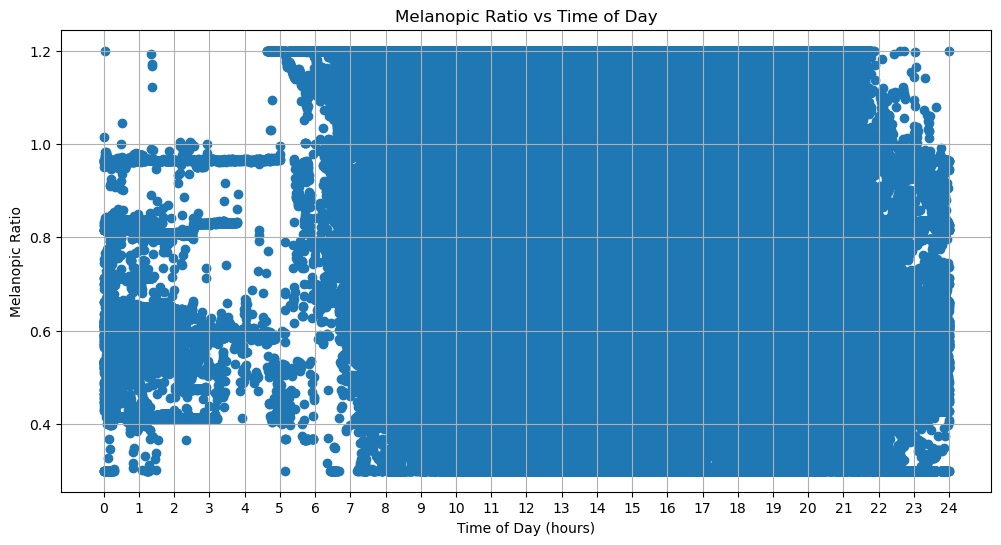

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(light['timeofday'], light['mel_ratio'])
plt.title('Melanopic Ratio vs Time of Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('Melanopic Ratio')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

calculate CCT values according to standard LED CCT values and typical melanopic ratio <br>
https://luminusdevices.zendesk.com/hc/en-us/articles/4409868024461-What-is-the-Melanopic-Ratio <br>
<img src="mceclip2.png" alt="CCT-MR" width="300">

In [30]:
# Estimate CCT from ratio

# Known points from your uploaded chart
melanopic_ratios = np.array([0.399, 0.442, 0.525, 0.631, 0.668, 0.836, 0.976])
cct_values = np.array([2400, 2700, 3000, 3500, 4000, 5000, 6500])

# Build interpolation function
mel_ratio_to_cct = interp1d(melanopic_ratios, cct_values, kind='linear', fill_value='extrapolate')

In [31]:
light['CCT_estimated'] = mel_ratio_to_cct(light['mel_ratio'])

In [32]:
light

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated
2,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695
3,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910
4,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493
5,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728
6,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249
...,...,...,...,...,...,...,...,...,...,...,...
1206086,59,2022-07-04 17:32:27,3253.818083,4248.832824,5691.571718,4657.706386,4401.393420,4637.623721,17.541,0.916166,5858.920621
1206087,59,2022-07-04 17:32:57,2662.712118,3977.842092,5276.498042,4328.537659,4034.605789,4303.364421,17.549,0.924356,5946.674838
1206088,59,2022-07-04 17:33:27,2009.047735,2976.460449,3998.311158,3244.904181,3070.297696,3345.245794,17.558,0.889758,5575.982551
1206089,59,2022-07-04 17:33:57,1149.363852,4085.682310,2345.986118,1896.283686,1761.784260,4461.917629,17.566,0.915679,5853.698859


In [33]:
light = light.dropna(subset=['PhotopicLux', 'mel_ratio'])

In [34]:
light

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated
2,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695
3,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910
4,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493
5,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728
6,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249
...,...,...,...,...,...,...,...,...,...,...,...
1206086,59,2022-07-04 17:32:27,3253.818083,4248.832824,5691.571718,4657.706386,4401.393420,4637.623721,17.541,0.916166,5858.920621
1206087,59,2022-07-04 17:32:57,2662.712118,3977.842092,5276.498042,4328.537659,4034.605789,4303.364421,17.549,0.924356,5946.674838
1206088,59,2022-07-04 17:33:27,2009.047735,2976.460449,3998.311158,3244.904181,3070.297696,3345.245794,17.558,0.889758,5575.982551
1206089,59,2022-07-04 17:33:57,1149.363852,4085.682310,2345.986118,1896.283686,1761.784260,4461.917629,17.566,0.915679,5853.698859


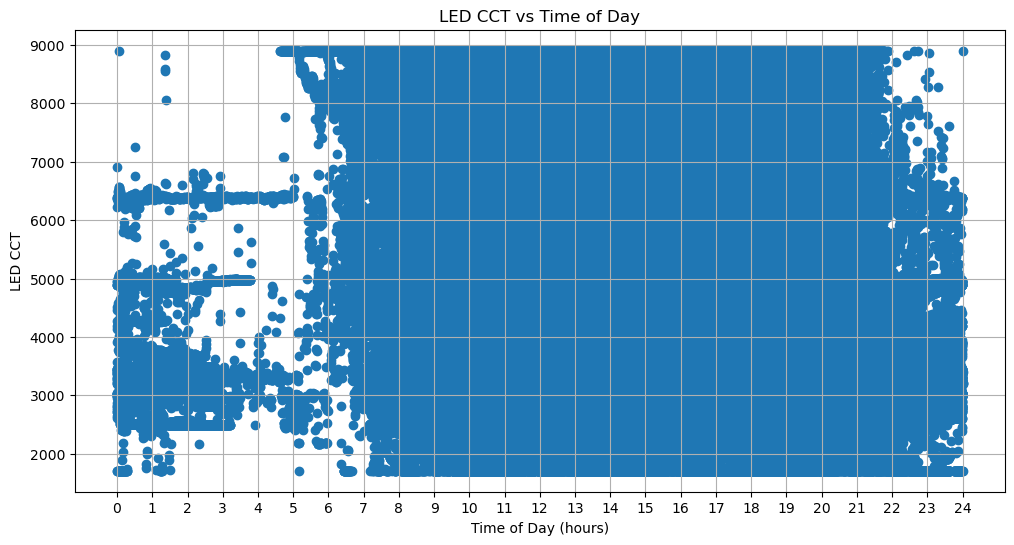

In [35]:
plt.figure(figsize=(12, 6))
plt.scatter(light['timeofday'], light['CCT_estimated'])
plt.title('LED CCT vs Time of Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('LED CCT')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

In [36]:
print(light['PhotopicLux'])

2           409.871875
3           372.004450
4           461.482365
5           550.446282
6           555.233814
              ...     
1206086    4637.623721
1206087    4303.364421
1206088    3345.245794
1206089    4461.917629
1206090    6152.290326
Name: PhotopicLux, Length: 413211, dtype: float64


In [37]:
print(light['PhotopicLux'].describe())

count    413211.000000
mean       1050.684879
std        2088.773015
min          50.056239
25%         132.296587
50%         279.230861
75%         785.366443
max       19923.655245
Name: PhotopicLux, dtype: float64


In [38]:
light.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated
2,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695
3,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910


In [39]:
kss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1799 non-null   int64  
 1   datatime   1799 non-null   object 
 2   timeofday  1799 non-null   float64
 3   timeawake  1781 non-null   float64
 4   kss        1799 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 70.4+ KB


In [40]:
kss['datatime'] = pd.to_datetime(kss['datatime'], errors='coerce')

In [41]:
kss.info()
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         1799 non-null   int64         
 1   datatime   1799 non-null   datetime64[ns]
 2   timeofday  1799 non-null   float64       
 3   timeawake  1781 non-null   float64       
 4   kss        1799 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 70.4 KB
<class 'pandas.core.frame.DataFrame'>
Index: 413211 entries, 2 to 1206090
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             413211 non-null  int64         
 1   datatime       413210 non-null  datetime64[ns]
 2   SconeopicEDI   413211 non-null  float64       
 3   MelanopicEDI   413211 non-null  float64       
 4   RodopicEDI     413211 non-null  float64       
 5   MconeopicEDI   4132

In [42]:
light

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated
2,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695
3,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910
4,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493
5,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728
6,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249
...,...,...,...,...,...,...,...,...,...,...,...
1206086,59,2022-07-04 17:32:27,3253.818083,4248.832824,5691.571718,4657.706386,4401.393420,4637.623721,17.541,0.916166,5858.920621
1206087,59,2022-07-04 17:32:57,2662.712118,3977.842092,5276.498042,4328.537659,4034.605789,4303.364421,17.549,0.924356,5946.674838
1206088,59,2022-07-04 17:33:27,2009.047735,2976.460449,3998.311158,3244.904181,3070.297696,3345.245794,17.558,0.889758,5575.982551
1206089,59,2022-07-04 17:33:57,1149.363852,4085.682310,2345.986118,1896.283686,1761.784260,4461.917629,17.566,0.915679,5853.698859


In [43]:
kss

,id,datatime,timeofday,timeawake,kss
0,1,2022-02-21 12:43:15,12.717,5.217000,3
1,1,2022-02-21 12:45:30,12.750,5.250000,3
2,1,2022-02-21 14:08:10,14.133,6.633000,4
3,1,2022-02-21 15:19:15,15.317,7.817000,5
4,1,2022-02-21 17:06:15,17.100,9.600000,6
...,...,...,...,...,...
1794,59,2022-07-03 12:44:54,12.742,0.075333,8
1795,59,2022-07-03 20:21:16,20.350,7.683333,7
1796,59,2022-07-04 09:20:04,9.333,0.333000,9
1797,59,2022-07-04 09:22:40,9.375,0.375000,9


In [44]:
# Ensure timestamps are datetime and data is sorted
kss['datatime'] = pd.to_datetime(kss['datatime'])
light['datatime'] = pd.to_datetime(light['datatime'])

kss = kss.sort_values(['id', 'datatime']).reset_index(drop=True)
light = light.sort_values(['id', 'datatime']).reset_index(drop=True)
light['kss'] = None  # Add column to store KSS labels

# Process by ID group
for subject_id in kss['id'].unique():
    kss_group = kss[kss['id'] == subject_id].reset_index(drop=True)
    lighting_group_mask = light['id'] == subject_id

    for i in range(len(kss_group)):
        t_curr = kss_group.loc[i, 'datatime']
        kss_val = kss_group.loc[i, 'kss']

        # Determine time window
        if i == 0:
            time_window = timedelta(minutes=30)
        else:
            t_prev = kss_group.loc[i - 1, 'datatime']
            time_window = min(t_curr - t_prev, timedelta(minutes=30))

        # Define time range
        start_time = t_curr - time_window
        end_time = t_curr

        # Build mask for lighting data
        mask = (
            lighting_group_mask &
            (light['datatime'] > start_time) &
            (light['datatime'] <= end_time) &
            (light['kss'].isna())  # only assign if not already labeled
        )

        light.loc[mask, 'kss'] = kss_val


In [45]:
light.tail(145)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss
413066,59,2022-07-03 22:12:27,27.956105,45.397011,89.774316,65.322878,60.140786,72.918044,22.207,0.622576,3460.263311,None
413067,59,2022-07-03 22:12:57,28.023992,45.439830,89.637301,65.205071,59.965364,72.940340,22.216,0.622973,3462.134703,None
413068,59,2022-07-03 22:13:27,27.858202,45.407342,89.365521,65.047140,59.836750,72.892024,22.224,0.622940,3461.980174,None
413069,59,2022-07-03 22:13:57,28.132427,45.473150,90.210961,65.386541,60.370860,72.912933,22.232,0.623664,3465.394827,None
413070,59,2022-07-03 22:14:27,27.948925,45.566432,89.923554,65.369514,60.300617,73.003938,22.241,0.624164,3467.754873,None
...,...,...,...,...,...,...,...,...,...,...,...,...
413206,59,2022-07-04 17:32:27,3253.818083,4248.832824,5691.571718,4657.706386,4401.393420,4637.623721,17.541,0.916166,5858.920621,None
413207,59,2022-07-04 17:32:57,2662.712118,3977.842092,5276.498042,4328.537659,4034.605789,4303.364421,17.549,0.924356,5946.674838,None
413208,59,2022-07-04 17:33:27,2009.047735,2976.460449,3998.311158,3244.904181,3070.297696,3345.245794,17.558,0.889758,5575.982551,None
413209,59,2022-07-04 17:33:57,1149.363852,4085.682310,2345.986118,1896.283686,1761.784260,4461.917629,17.566,0.915679,5853.698859,None


In [46]:
filtered = light[light['kss'].notna()].reset_index(drop=True)

In [47]:
filtered

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695,3
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910,3
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493,3
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728,3
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249,3
...,...,...,...,...,...,...,...,...,...,...,...,...
42592,59,2022-06-30 10:54:57,76.161964,99.796386,133.181116,110.930422,112.090750,105.927232,10.916,0.942122,6137.022496,4
42593,59,2022-06-30 10:55:27,71.462525,96.590525,124.668014,103.988856,104.982251,102.615033,10.924,0.941290,6128.109275,4
42594,59,2022-06-30 10:55:57,69.748097,94.523579,121.617204,101.634836,102.627789,100.495286,10.932,0.940577,6120.470470,4
42595,59,2022-06-30 10:56:27,69.024726,91.742479,120.888039,100.909189,102.013878,97.640157,10.941,0.939598,6109.976614,4


In [48]:
filtered = filtered.sort_values(by=['id', 'datatime']).reset_index(drop=True)

In [49]:
filtered

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695,3
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910,3
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493,3
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728,3
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249,3
...,...,...,...,...,...,...,...,...,...,...,...,...
42592,59,2022-06-30 10:54:57,76.161964,99.796386,133.181116,110.930422,112.090750,105.927232,10.916,0.942122,6137.022496,4
42593,59,2022-06-30 10:55:27,71.462525,96.590525,124.668014,103.988856,104.982251,102.615033,10.924,0.941290,6128.109275,4
42594,59,2022-06-30 10:55:57,69.748097,94.523579,121.617204,101.634836,102.627789,100.495286,10.932,0.940577,6120.470470,4
42595,59,2022-06-30 10:56:27,69.024726,91.742479,120.888039,100.909189,102.013878,97.640157,10.941,0.939598,6109.976614,4


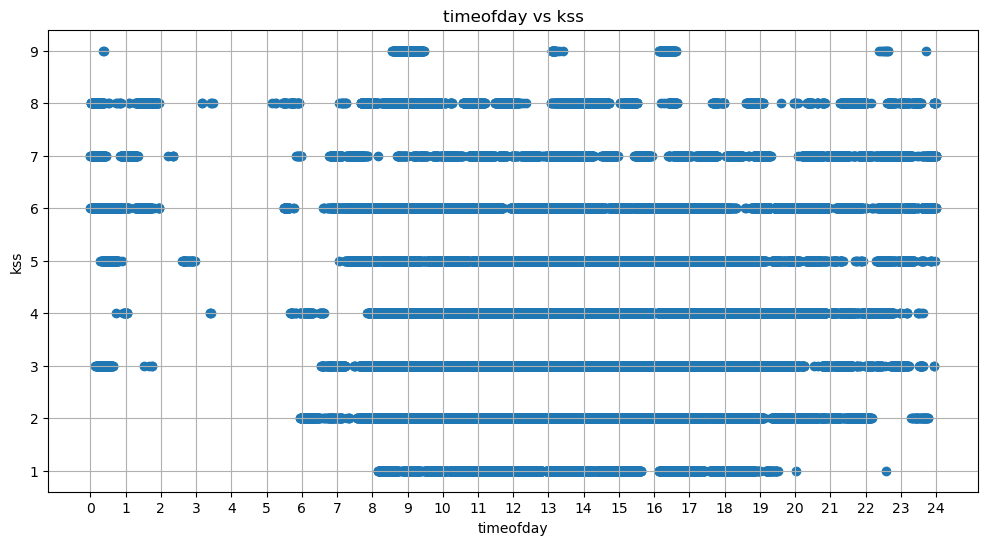

In [50]:
plt.figure(figsize=(12, 6))
plt.scatter(filtered['timeofday'], filtered['kss'])
plt.title('timeofday vs kss')
plt.xlabel('timeofday')
plt.ylabel('kss')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

In [51]:
filtered.isnull().sum()

id               0
datatime         0
SconeopicEDI     0
MelanopicEDI     0
RodopicEDI       0
MconeopicEDI     0
LconeopicEDI     0
PhotopicLux      0
timeofday        0
mel_ratio        0
CCT_estimated    0
kss              0
dtype: int64

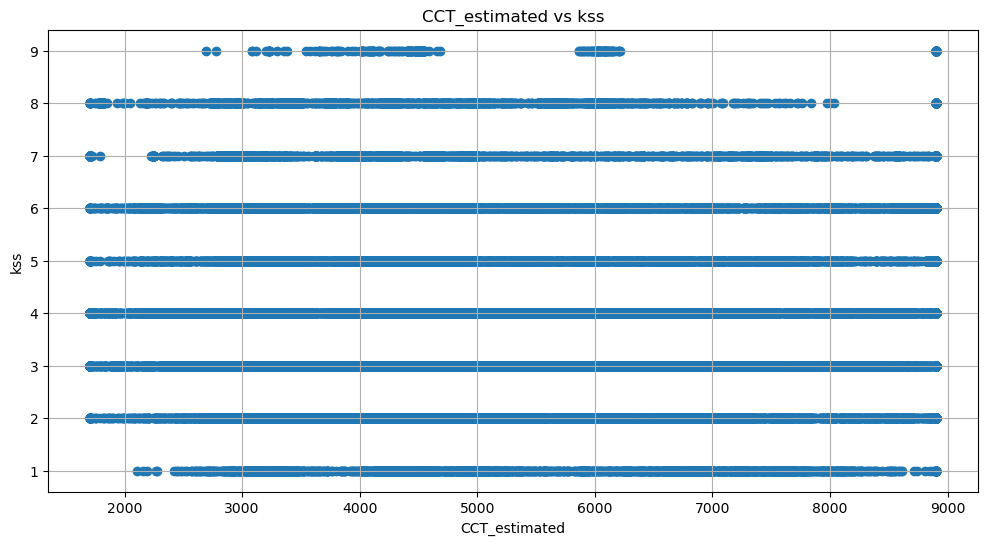

In [52]:
plt.figure(figsize=(12, 6))
plt.scatter(filtered['CCT_estimated'], filtered['kss'])
plt.title('CCT_estimated vs kss')
plt.xlabel('CCT_estimated')
plt.ylabel('kss')
plt.grid(True)
plt.show()

In [53]:
def get_day_phase(hour):
    if 6 <= hour < 18:
        return 'day'
    else:
        return 'night'

filtered['hour'] = filtered['datatime'].dt.hour
filtered['day_phase'] = filtered['hour'].apply(get_day_phase)

In [54]:
filtered.head(2)

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss,hour,day_phase
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695,3,12,day
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910,3,12,day


In [55]:
# For daytime samples, keep alert (low KSS)
day_samples = filtered[(filtered['day_phase'] == 'day') & (filtered['kss'] <= 5)]

# For nighttime samples, keep sleepy (high KSS)
night_samples = filtered[(filtered['day_phase'] == 'night') & (filtered['kss'] >= 6)]

# Combine
good_circadian = pd.concat([day_samples, night_samples])

In [56]:
good_circadian

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss,hour,day_phase
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695,3,12,day
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910,3,12,day
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493,3,12,day
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728,3,12,day
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249,3,12,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42470,59,2022-06-29 00:20:57,24.170873,35.848582,81.253181,52.313170,52.922300,54.511017,0.349,0.657639,3859.989462,8,0,night
42471,59,2022-06-29 00:29:57,23.432972,34.394634,75.580988,50.955985,47.683533,55.684990,0.499,0.617664,3437.096066,8,0,night
42472,59,2022-06-29 00:30:57,14.410925,36.505835,37.146394,36.633560,20.748596,59.644918,0.516,0.612053,3410.626047,8,0,night
42473,59,2022-06-29 00:43:27,21.205208,38.929243,65.708868,55.598958,55.162881,63.941057,0.724,0.608830,3395.425184,8,0,night


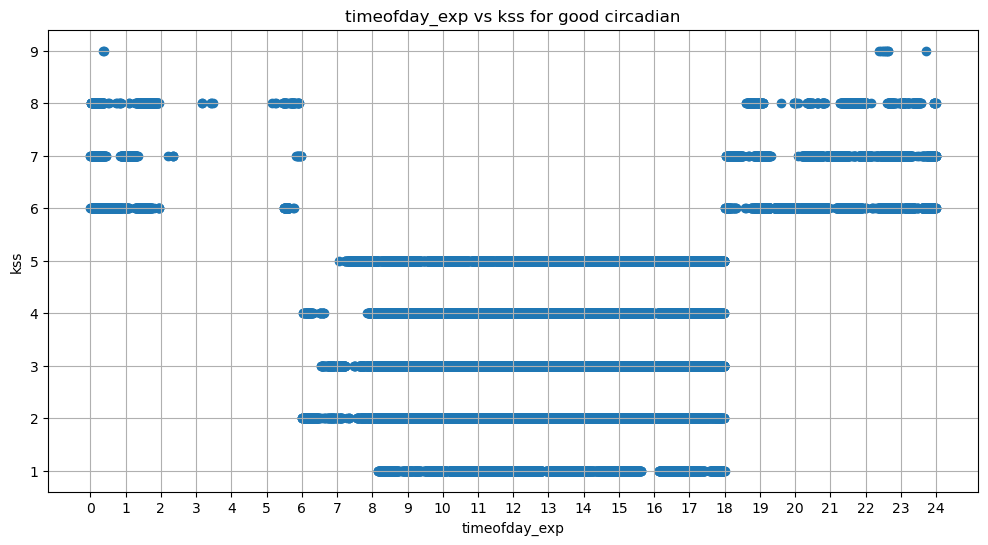

In [57]:
plt.figure(figsize=(12, 6))
plt.scatter(good_circadian['timeofday'], good_circadian['kss'])
plt.title('timeofday_exp vs kss for good circadian')
plt.xlabel('timeofday_exp')
plt.ylabel('kss')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

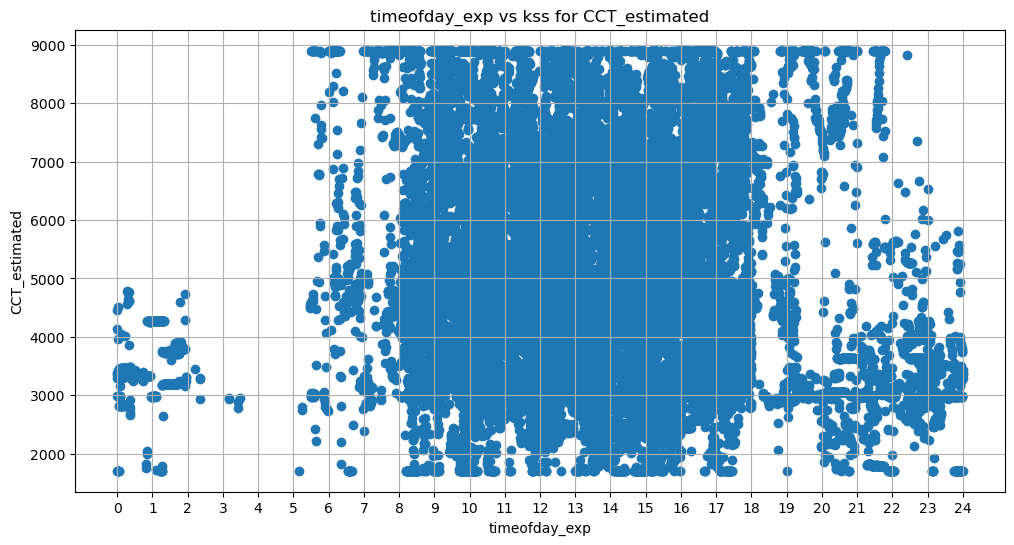

In [58]:
plt.figure(figsize=(12, 6))
plt.scatter(good_circadian['timeofday'], good_circadian['CCT_estimated'])
plt.title('timeofday_exp vs kss for CCT_estimated')
plt.xlabel('timeofday_exp')
plt.ylabel('CCT_estimated')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

In [59]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    59 non-null     int64  
 1   age                   59 non-null     object 
 2   sex                   59 non-null     object 
 3   caffeineGeneralUnit   58 non-null     float64
 4   smokeGeneralUnit      59 non-null     object 
 5   alcoholGeneralFreq    59 non-null     object 
 6   healthSubjRate        59 non-null     object 
 7   chronotypeSubjRate    59 non-null     object 
 8   PSQItotalScore        59 non-null     int64  
 9   MCTQmsfsc             59 non-null     float64
 10  IPAQactivityCategory  59 non-null     object 
dtypes: float64(2), int64(2), object(7)
memory usage: 5.2+ KB


In [60]:
# Keep only needed columns
baseline = baseline[['id', 'age', 'sex', 'chronotypeSubjRate']]

# Merge with your main dataset (e.g., merged or kss)
good_circadian = good_circadian.merge(baseline, on='id', how='left')  # or merged = merged.merge(...)

In [61]:
good_circadian

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss,hour,day_phase,age,sex,chronotypeSubjRate
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695,3,12,day,26-30,Male,Rather more an evening type than a morning type
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910,3,12,day,26-30,Male,Rather more an evening type than a morning type
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493,3,12,day,26-30,Male,Rather more an evening type than a morning type
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728,3,12,day,26-30,Male,Rather more an evening type than a morning type
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249,3,12,day,26-30,Male,Rather more an evening type than a morning type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31078,59,2022-06-29 00:20:57,24.170873,35.848582,81.253181,52.313170,52.922300,54.511017,0.349,0.657639,3859.989462,8,0,night,18-25,Female,Definitely an evening type
31079,59,2022-06-29 00:29:57,23.432972,34.394634,75.580988,50.955985,47.683533,55.684990,0.499,0.617664,3437.096066,8,0,night,18-25,Female,Definitely an evening type
31080,59,2022-06-29 00:30:57,14.410925,36.505835,37.146394,36.633560,20.748596,59.644918,0.516,0.612053,3410.626047,8,0,night,18-25,Female,Definitely an evening type
31081,59,2022-06-29 00:43:27,21.205208,38.929243,65.708868,55.598958,55.162881,63.941057,0.724,0.608830,3395.425184,8,0,night,18-25,Female,Definitely an evening type


In [62]:
good_circadian['date'] = pd.to_datetime(good_circadian['datatime']).dt.date
sleep['date'] = pd.to_datetime(sleep['datatime'], dayfirst=True).dt.date

In [63]:
df = pd.merge(
    good_circadian,
    sleep[['id', 'date', 'wakeTimeToday', 'sleepDurationYesterday']],
    on=['id', 'date'],
    how='left'
)

In [64]:
df

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss,hour,day_phase,age,sex,chronotypeSubjRate,date,wakeTimeToday,sleepDurationYesterday
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,3432.964695,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,3382.927910,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,3436.431493,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,3343.724728,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,3949.113249,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31167,59,2022-06-29 00:20:57,24.170873,35.848582,81.253181,52.313170,52.922300,54.511017,0.349,0.657639,3859.989462,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0
31168,59,2022-06-29 00:29:57,23.432972,34.394634,75.580988,50.955985,47.683533,55.684990,0.499,0.617664,3437.096066,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0
31169,59,2022-06-29 00:30:57,14.410925,36.505835,37.146394,36.633560,20.748596,59.644918,0.516,0.612053,3410.626047,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0
31170,59,2022-06-29 00:43:27,21.205208,38.929243,65.708868,55.598958,55.162881,63.941057,0.724,0.608830,3395.425184,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31172 entries, 0 to 31171
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      31172 non-null  int64         
 1   datatime                31172 non-null  datetime64[ns]
 2   SconeopicEDI            31172 non-null  float64       
 3   MelanopicEDI            31172 non-null  float64       
 4   RodopicEDI              31172 non-null  float64       
 5   MconeopicEDI            31172 non-null  float64       
 6   LconeopicEDI            31172 non-null  float64       
 7   PhotopicLux             31172 non-null  float64       
 8   timeofday               31172 non-null  float64       
 9   mel_ratio               31172 non-null  float64       
 10  CCT_estimated           31172 non-null  float64       
 11  kss                     31172 non-null  object        
 12  hour                    31172 non-null  int32 

In [66]:
df['timeofday_sec'] = df['datatime'].dt.hour * 3600 + df['datatime'].dt.minute * 60 + df['datatime'].dt.second

In [67]:
df

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,...,kss,hour,day_phase,age,sex,chronotypeSubjRate,date,wakeTimeToday,sleepDurationYesterday,timeofday_sec
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,...,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0,45240
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,...,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0,45270
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,...,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0,45300
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,...,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0,45330
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,...,3,12,day,26-30,Male,Rather more an evening type than a morning type,2022-02-21,7.5,8.0,45360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31167,59,2022-06-29 00:20:57,24.170873,35.848582,81.253181,52.313170,52.922300,54.511017,0.349,0.657639,...,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0,1257
31168,59,2022-06-29 00:29:57,23.432972,34.394634,75.580988,50.955985,47.683533,55.684990,0.499,0.617664,...,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0,1797
31169,59,2022-06-29 00:30:57,14.410925,36.505835,37.146394,36.633560,20.748596,59.644918,0.516,0.612053,...,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0,1857
31170,59,2022-06-29 00:43:27,21.205208,38.929243,65.708868,55.598958,55.162881,63.941057,0.724,0.608830,...,8,0,night,18-25,Female,Definitely an evening type,2022-06-29,9.0,8.0,2607


In [68]:
print(df['wakeTimeToday'].unique())

[ 7.5         8.5         9.          8.         12.          9.5
  7.25       10.          6.41666667  5.5         6.75        7.16666667
  6.91666667  5.91666667  5.08333333  6.          6.5         9.66666667
 10.5                nan  7.          6.66666667  6.83333333  4.5
  6.25        8.91666667  8.41666667  8.58333333  7.33333333  7.66666667
  8.08333333  7.75        7.83333333 11.          9.25       10.66666667
  9.83333333  7.08333333  8.33333333  8.16666667  5.         11.5
  8.66666667  8.83333333  8.25        5.58333333  5.33333333  5.75
  5.16666667  7.58333333  9.16666667  9.41666667  9.75       10.58333333
 13.         12.25       16.25       11.91666667  5.66666667  9.33333333
 10.16666667 10.25       10.75       13.58333333  7.41666667 12.83333333
  8.75       11.33333333  6.16666667  6.33333333  7.91666667  6.58333333
 15.        ]


In [69]:
df['wakeTimeToday_seconds'] = df['wakeTimeToday'] * 3600
df['wakeTime_sin'] = np.sin(2 * np.pi * df['wakeTimeToday_seconds'] / 86400)
df['wakeTime_cos'] = np.cos(2 * np.pi * df['wakeTimeToday_seconds'] / 86400)

In [70]:
# Define total seconds in a day
SECONDS_IN_DAY = 86400

# Create cyclical features
df['time_sin'] = np.sin(2 * np.pi * df['timeofday_sec'] / SECONDS_IN_DAY)
df['time_cos'] = np.cos(2 * np.pi * df['timeofday_sec'] / SECONDS_IN_DAY)

In [71]:
df['sleepDuration_sec'] = df['sleepDurationYesterday'] * 3600

In [72]:
df

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,...,date,wakeTimeToday,sleepDurationYesterday,timeofday_sec,wakeTimeToday_seconds,wakeTime_sin,wakeTime_cos,time_sin,time_cos,sleepDuration_sec
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,...,2022-02-21,7.5,8.0,45240,27000.0,0.923880,-0.382683,-0.147809,-0.989016,28800.0
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,...,2022-02-21,7.5,8.0,45270,27000.0,0.923880,-0.382683,-0.149967,-0.988691,28800.0
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,...,2022-02-21,7.5,8.0,45300,27000.0,0.923880,-0.382683,-0.152123,-0.988362,28800.0
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,...,2022-02-21,7.5,8.0,45330,27000.0,0.923880,-0.382683,-0.154279,-0.988027,28800.0
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,...,2022-02-21,7.5,8.0,45360,27000.0,0.923880,-0.382683,-0.156434,-0.987688,28800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31167,59,2022-06-29 00:20:57,24.170873,35.848582,81.253181,52.313170,52.922300,54.511017,0.349,0.657639,...,2022-06-29,9.0,8.0,1257,32400.0,0.707107,-0.707107,0.091284,0.995825,28800.0
31168,59,2022-06-29 00:29:57,23.432972,34.394634,75.580988,50.955985,47.683533,55.684990,0.499,0.617664,...,2022-06-29,9.0,8.0,1797,32400.0,0.707107,-0.707107,0.130310,0.991473,28800.0
31169,59,2022-06-29 00:30:57,14.410925,36.505835,37.146394,36.633560,20.748596,59.644918,0.516,0.612053,...,2022-06-29,9.0,8.0,1857,32400.0,0.707107,-0.707107,0.134635,0.990895,28800.0
31170,59,2022-06-29 00:43:27,21.205208,38.929243,65.708868,55.598958,55.162881,63.941057,0.724,0.608830,...,2022-06-29,9.0,8.0,2607,32400.0,0.707107,-0.707107,0.188453,0.982082,28800.0


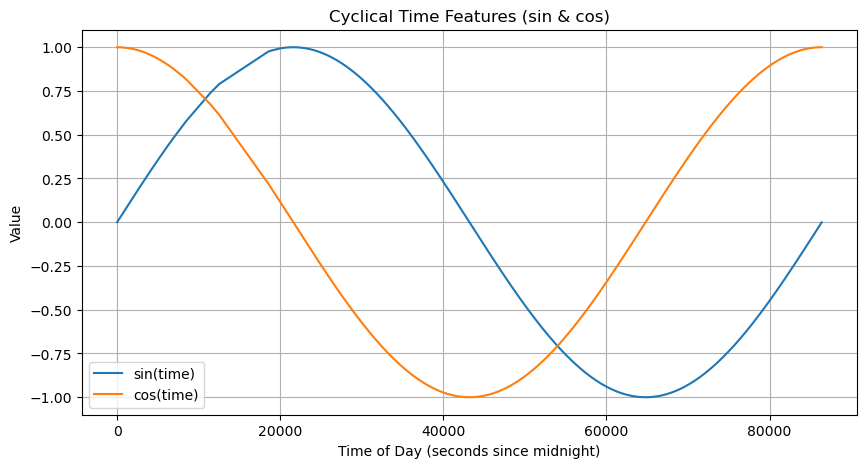

In [73]:
df_sorted = df.sort_values('timeofday_sec')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_sorted['timeofday_sec'], df_sorted['time_sin'], label='sin(time)')
plt.plot(df_sorted['timeofday_sec'], df_sorted['time_cos'], label='cos(time)')
plt.xlabel('Time of Day (seconds since midnight)')
plt.ylabel('Value')
plt.title('Cyclical Time Features (sin & cos)')
plt.legend()
plt.grid(True)
plt.show()

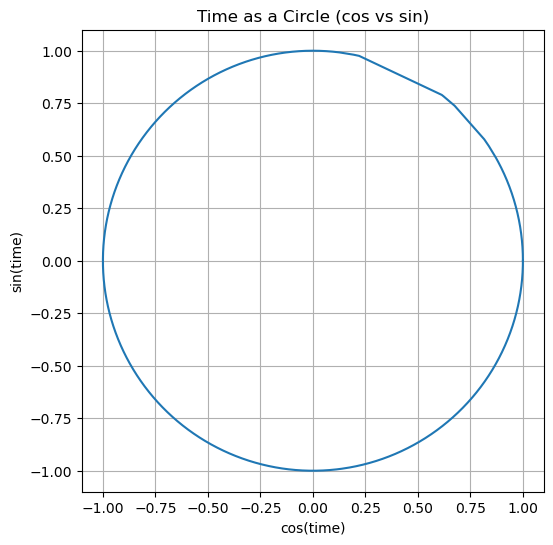

In [74]:
plt.figure(figsize=(6, 6))
plt.plot(df_sorted['time_cos'], df_sorted['time_sin'], label='Time circle')
plt.xlabel('cos(time)')
plt.ylabel('sin(time)')
plt.title('Time as a Circle (cos vs sin)')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

In [75]:
#age average
def parse_age(val):
    if isinstance(val, str) and '-' in val:
        a, b = val.split('-')
        return (int(a) + int(b)) / 2
    try:
        return float(val)
    except:
        return np.nan

df['age_numeric'] = df['age'].apply(parse_age)

In [76]:
df

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,...,wakeTimeToday,sleepDurationYesterday,timeofday_sec,wakeTimeToday_seconds,wakeTime_sin,wakeTime_cos,time_sin,time_cos,sleepDuration_sec,age_numeric
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,...,7.5,8.0,45240,27000.0,0.923880,-0.382683,-0.147809,-0.989016,28800.0,28.0
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,...,7.5,8.0,45270,27000.0,0.923880,-0.382683,-0.149967,-0.988691,28800.0,28.0
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,...,7.5,8.0,45300,27000.0,0.923880,-0.382683,-0.152123,-0.988362,28800.0,28.0
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,...,7.5,8.0,45330,27000.0,0.923880,-0.382683,-0.154279,-0.988027,28800.0,28.0
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,...,7.5,8.0,45360,27000.0,0.923880,-0.382683,-0.156434,-0.987688,28800.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31167,59,2022-06-29 00:20:57,24.170873,35.848582,81.253181,52.313170,52.922300,54.511017,0.349,0.657639,...,9.0,8.0,1257,32400.0,0.707107,-0.707107,0.091284,0.995825,28800.0,21.5
31168,59,2022-06-29 00:29:57,23.432972,34.394634,75.580988,50.955985,47.683533,55.684990,0.499,0.617664,...,9.0,8.0,1797,32400.0,0.707107,-0.707107,0.130310,0.991473,28800.0,21.5
31169,59,2022-06-29 00:30:57,14.410925,36.505835,37.146394,36.633560,20.748596,59.644918,0.516,0.612053,...,9.0,8.0,1857,32400.0,0.707107,-0.707107,0.134635,0.990895,28800.0,21.5
31170,59,2022-06-29 00:43:27,21.205208,38.929243,65.708868,55.598958,55.162881,63.941057,0.724,0.608830,...,9.0,8.0,2607,32400.0,0.707107,-0.707107,0.188453,0.982082,28800.0,21.5


In [77]:
df['sex_encoded'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

In [78]:
df['log_lux'] = np.log1p(df['PhotopicLux'])

In [79]:
df

,id,datatime,SconeopicEDI,MelanopicEDI,RodopicEDI,MconeopicEDI,LconeopicEDI,PhotopicLux,timeofday,mel_ratio,...,timeofday_sec,wakeTimeToday_seconds,wakeTime_sin,wakeTime_cos,time_sin,time_cos,sleepDuration_sec,age_numeric,sex_encoded,log_lux
0,1,2022-02-21 12:34:00,148.126443,252.804266,109.944697,115.173327,94.927285,409.871875,12.567,0.616789,...,45240,27000.0,0.923880,-0.382683,-0.147809,-0.989016,28800.0,28.0,1,6.018281
1,1,2022-02-21 12:34:30,23.922818,225.501924,280.754992,488.708210,616.006479,372.004450,12.575,0.606181,...,45270,27000.0,0.923880,-0.382683,-0.149967,-0.988691,28800.0,28.0,1,5.921590
2,1,2022-02-21 12:35:00,360.207330,284.976194,455.501441,625.170105,668.800388,461.482365,12.583,0.617523,...,45300,27000.0,0.923880,-0.382683,-0.152123,-0.988362,28800.0,28.0,1,6.136608
3,1,2022-02-21 12:35:30,156.518838,329.095122,234.407020,335.533416,372.904136,550.446282,12.592,0.597870,...,45330,27000.0,0.923880,-0.382683,-0.154279,-0.988027,28800.0,28.0,1,6.312544
4,1,2022-02-21 12:36:00,260.760111,368.805389,362.008904,509.618044,556.406727,555.233814,12.600,0.664234,...,45360,27000.0,0.923880,-0.382683,-0.156434,-0.987688,28800.0,28.0,1,6.321189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31167,59,2022-06-29 00:20:57,24.170873,35.848582,81.253181,52.313170,52.922300,54.511017,0.349,0.657639,...,1257,32400.0,0.707107,-0.707107,0.091284,0.995825,28800.0,21.5,0,4.016581
31168,59,2022-06-29 00:29:57,23.432972,34.394634,75.580988,50.955985,47.683533,55.684990,0.499,0.617664,...,1797,32400.0,0.707107,-0.707107,0.130310,0.991473,28800.0,21.5,0,4.037509
31169,59,2022-06-29 00:30:57,14.410925,36.505835,37.146394,36.633560,20.748596,59.644918,0.516,0.612053,...,1857,32400.0,0.707107,-0.707107,0.134635,0.990895,28800.0,21.5,0,4.105036
31170,59,2022-06-29 00:43:27,21.205208,38.929243,65.708868,55.598958,55.162881,63.941057,0.724,0.608830,...,2607,32400.0,0.707107,-0.707107,0.188453,0.982082,28800.0,21.5,0,4.173480


In [80]:
drop_cols = [
    'SconeopicEDI', 'RodopicEDI', 'MconeopicEDI', 'LconeopicEDI',
     'day_phase', 'hour', 'date', 'age'
]
df = df.drop(columns=drop_cols, errors='ignore')

In [81]:
df

,id,datatime,MelanopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss,sex,chronotypeSubjRate,...,timeofday_sec,wakeTimeToday_seconds,wakeTime_sin,wakeTime_cos,time_sin,time_cos,sleepDuration_sec,age_numeric,sex_encoded,log_lux
0,1,2022-02-21 12:34:00,252.804266,409.871875,12.567,0.616789,3432.964695,3,Male,Rather more an evening type than a morning type,...,45240,27000.0,0.923880,-0.382683,-0.147809,-0.989016,28800.0,28.0,1,6.018281
1,1,2022-02-21 12:34:30,225.501924,372.004450,12.575,0.606181,3382.927910,3,Male,Rather more an evening type than a morning type,...,45270,27000.0,0.923880,-0.382683,-0.149967,-0.988691,28800.0,28.0,1,5.921590
2,1,2022-02-21 12:35:00,284.976194,461.482365,12.583,0.617523,3436.431493,3,Male,Rather more an evening type than a morning type,...,45300,27000.0,0.923880,-0.382683,-0.152123,-0.988362,28800.0,28.0,1,6.136608
3,1,2022-02-21 12:35:30,329.095122,550.446282,12.592,0.597870,3343.724728,3,Male,Rather more an evening type than a morning type,...,45330,27000.0,0.923880,-0.382683,-0.154279,-0.988027,28800.0,28.0,1,6.312544
4,1,2022-02-21 12:36:00,368.805389,555.233814,12.600,0.664234,3949.113249,3,Male,Rather more an evening type than a morning type,...,45360,27000.0,0.923880,-0.382683,-0.156434,-0.987688,28800.0,28.0,1,6.321189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31167,59,2022-06-29 00:20:57,35.848582,54.511017,0.349,0.657639,3859.989462,8,Female,Definitely an evening type,...,1257,32400.0,0.707107,-0.707107,0.091284,0.995825,28800.0,21.5,0,4.016581
31168,59,2022-06-29 00:29:57,34.394634,55.684990,0.499,0.617664,3437.096066,8,Female,Definitely an evening type,...,1797,32400.0,0.707107,-0.707107,0.130310,0.991473,28800.0,21.5,0,4.037509
31169,59,2022-06-29 00:30:57,36.505835,59.644918,0.516,0.612053,3410.626047,8,Female,Definitely an evening type,...,1857,32400.0,0.707107,-0.707107,0.134635,0.990895,28800.0,21.5,0,4.105036
31170,59,2022-06-29 00:43:27,38.929243,63.941057,0.724,0.608830,3395.425184,8,Female,Definitely an evening type,...,2607,32400.0,0.707107,-0.707107,0.188453,0.982082,28800.0,21.5,0,4.173480


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31172 entries, 0 to 31171
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      31172 non-null  int64         
 1   datatime                31172 non-null  datetime64[ns]
 2   MelanopicEDI            31172 non-null  float64       
 3   PhotopicLux             31172 non-null  float64       
 4   timeofday               31172 non-null  float64       
 5   mel_ratio               31172 non-null  float64       
 6   CCT_estimated           31172 non-null  float64       
 7   kss                     31172 non-null  object        
 8   sex                     31172 non-null  object        
 9   chronotypeSubjRate      31172 non-null  object        
 10  wakeTimeToday           31003 non-null  float64       
 11  sleepDurationYesterday  31003 non-null  float64       
 12  timeofday_sec           31172 non-null  int32 

In [83]:
df['kss'] = df['kss'].astype(int)

In [84]:
df['chronotypeSubjRate'].value_counts()

chronotypeSubjRate
Rather more a morning type than an evening type    14019
Definitely an evening type                          7177
Rather more an evening type than a morning type     6965
Definitely a morning type                           3011
Name: count, dtype: int64

In [85]:
chronotype_map = {
    'Definitely a morning type': 0,
    'Rather more a morning type than an evening type': 1,
    'Rather more an evening type than a morning type': 2,
    'Definitely an evening type': 3
}

df['chronotype_encoded'] = df['chronotypeSubjRate'].map(chronotype_map)

In [86]:
df

,id,datatime,MelanopicEDI,PhotopicLux,timeofday,mel_ratio,CCT_estimated,kss,sex,chronotypeSubjRate,...,wakeTimeToday_seconds,wakeTime_sin,wakeTime_cos,time_sin,time_cos,sleepDuration_sec,age_numeric,sex_encoded,log_lux,chronotype_encoded
0,1,2022-02-21 12:34:00,252.804266,409.871875,12.567,0.616789,3432.964695,3,Male,Rather more an evening type than a morning type,...,27000.0,0.923880,-0.382683,-0.147809,-0.989016,28800.0,28.0,1,6.018281,2
1,1,2022-02-21 12:34:30,225.501924,372.004450,12.575,0.606181,3382.927910,3,Male,Rather more an evening type than a morning type,...,27000.0,0.923880,-0.382683,-0.149967,-0.988691,28800.0,28.0,1,5.921590,2
2,1,2022-02-21 12:35:00,284.976194,461.482365,12.583,0.617523,3436.431493,3,Male,Rather more an evening type than a morning type,...,27000.0,0.923880,-0.382683,-0.152123,-0.988362,28800.0,28.0,1,6.136608,2
3,1,2022-02-21 12:35:30,329.095122,550.446282,12.592,0.597870,3343.724728,3,Male,Rather more an evening type than a morning type,...,27000.0,0.923880,-0.382683,-0.154279,-0.988027,28800.0,28.0,1,6.312544,2
4,1,2022-02-21 12:36:00,368.805389,555.233814,12.600,0.664234,3949.113249,3,Male,Rather more an evening type than a morning type,...,27000.0,0.923880,-0.382683,-0.156434,-0.987688,28800.0,28.0,1,6.321189,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31167,59,2022-06-29 00:20:57,35.848582,54.511017,0.349,0.657639,3859.989462,8,Female,Definitely an evening type,...,32400.0,0.707107,-0.707107,0.091284,0.995825,28800.0,21.5,0,4.016581,3
31168,59,2022-06-29 00:29:57,34.394634,55.684990,0.499,0.617664,3437.096066,8,Female,Definitely an evening type,...,32400.0,0.707107,-0.707107,0.130310,0.991473,28800.0,21.5,0,4.037509,3
31169,59,2022-06-29 00:30:57,36.505835,59.644918,0.516,0.612053,3410.626047,8,Female,Definitely an evening type,...,32400.0,0.707107,-0.707107,0.134635,0.990895,28800.0,21.5,0,4.105036,3
31170,59,2022-06-29 00:43:27,38.929243,63.941057,0.724,0.608830,3395.425184,8,Female,Definitely an evening type,...,32400.0,0.707107,-0.707107,0.188453,0.982082,28800.0,21.5,0,4.173480,3


In [87]:
# Select features and targets
X = df[['age_numeric', 'sex_encoded','chronotype_encoded','sleepDuration_sec', 'wakeTime_sin','wakeTime_cos', 'time_sin', 'time_cos']]
y = df[['mel_ratio', 'log_lux']]

# Scale the outputs
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

In [88]:
# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [89]:
# Predict (scaled)
y_pred_scaled = model.predict(X_test)

# Unscale predictions and targets for evaluation
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Evaluate
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

MAE: 0.06790901413059393
R² Score: 0.9624125770045101


In [90]:
# Separate predictions
mel_pred = y_pred[:, 0]
lux_pred = y_pred[:, 1]
mel_true = y_true[:, 0]
lux_true = y_true[:, 1]

# Evaluate mel_ratio
print("mel_ratio MAE:", mean_absolute_error(mel_true, mel_pred))
print("mel_ratio R² Score:", r2_score(mel_true, mel_pred))

# Evaluate PhotopicLux
print("PhotopicLux MAE:", mean_absolute_error(lux_true, lux_pred))
print("PhotopicLux R² Score:", r2_score(lux_true, lux_pred))

mel_ratio MAE: 0.021005987672450693
mel_ratio R² Score: 0.9563149628181329
PhotopicLux MAE: 0.11481204058873712
PhotopicLux R² Score: 0.9685101911908877


In [91]:
# Save model
joblib.dump(model, 'models/model_1.0.pkl')

# Save scaler
joblib.dump(scaler_y, 'models/scaler_1.0.pkl')

['models/scaler_1.0.pkl']

In [92]:
# 5. Predict scaled output
y_pred_scaled = model.predict(X)
print(f"Scaled Prediction: {y_pred_scaled}")

# 6. Inverse scale to get true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
print(f"Inverse Scaled Prediction: {y_pred}")

Scaled Prediction: [[0.35050963 0.34792857]
 [0.34568399 0.34682534]
 [0.34767    0.37012389]
 ...
 [0.38001639 0.01706331]
 [0.33873234 0.04381228]
 [0.32427407 0.05451537]]
Inverse Scaled Prediction: [[0.61545866 5.99636527]
 [0.61111559 5.98983798]
 [0.612903   6.12768438]
 ...
 [0.64201475 4.03879283]
 [0.6048591  4.19705378]
 [0.59184667 4.26037887]]


In [93]:
print(f"Scaler y_min: {scaler_y.data_min_}")
print(f"Scaler y_max: {scaler_y.data_max_}")

Scaler y_min: [0.3        3.93783733]
Scaler y_max: [1.2        9.85436187]
